In [1]:
import numpy as np
import pymongo
import pymongo.database

import pandas as pd
import matplotlib.pyplot as plt


import sys
sys.path.append('../')
import src.IQ as IQ

## Connecting to the database

In [2]:
myclient = pymongo.MongoClient("mongodb://127.0.0.1:27017/admin")
BLE = myclient["BLE"]

def query(collection, filter:dict, addFrameColumn=True):
    df =  pd.DataFrame(list(collection.find(filter)))
    if addFrameColumn:
        df['frame'] = df.apply(lambda x: x['I'] + np.dot(x['Q'],1j), axis=1)
    return df.copy()


## Modifying the DataFram
### keeping the necessary colunms  only

In [3]:
def df_modify(df):
    if 'txPower' in df.columns:
        df_temp = df[['I','Q','frame','dvc','pos', 'antenna', 'txPower','SDR','frameChnl']].copy()
        df_temp['txPower'] = df.apply(lambda x: 9 if x['txPower'] == '9dbm' else 3, axis=1)
        df_temp[['dvc','pos', 'antenna', 'txPower','SDR','frameChnl']] = df_temp[['dvc','pos', 'antenna', 'txPower','SDR','frameChnl']].astype('int')
    else:
        df_temp = df[['I','Q','frame','dvc','pos', 'antenna', 'antenna_side','SDR','frameChnl']].copy()
        df_temp['antenna_side'] = df.apply(lambda x: 0 if x['antenna_side'] == 'left' else 1, axis=1)
        df_temp['pos'] = df.apply(lambda x: 0 if x['pos'] == 'static' else 1, axis=1)
        df_temp[['dvc','pos', 'antenna','SDR','frameChnl']] = df_temp[['dvc','pos', 'antenna','SDR','frameChnl']].astype('int')
    return df_temp.copy()

## Feature Extraction
### Extracting feature under differetn sampling rates and different filtering situations

In [4]:
iq = IQ.IQ(Fc=2439810000+1.5e4,Fs=100e6)
def configCreator(downSampleRate = 1, cutoff = 1e6):
    downSampleRate= max(downSampleRate, 1)
    return {                                      
            iq.bitFinderFromPhaseGradient:{'Fs': iq.Fs/downSampleRate, 'plot':False},
            iq.scalePhaseGradientToHz: {'Fs': iq.Fs/downSampleRate}, 
            iq.gradient:{},
            iq.unwrapPhase:{},
            iq.phase:{}, 
            iq.butter:{'Fs': iq.Fs/downSampleRate, "cutoff": cutoff},
            iq.downSample:{'downSampleRate':downSampleRate, "shift": 0},
            iq.demodulate:{'Fs': iq.Fs},
           }

def RSSIconfigCreator(downSampleRate = 1, cutoff = 1e6):
    downSampleRate= max(downSampleRate, 1)
    return {
            iq.rssi:{},                                      
            iq.butter:{'Fs': iq.Fs/downSampleRate, "cutoff": cutoff},
            iq.downSample:{'downSampleRate':downSampleRate, "shift": 0},
            iq.demodulate:{'Fs': iq.Fs},
           }

configurations = { 
    'butter4MHz_Fs100MHz': configCreator(downSampleRate = 1, cutoff=4e6), 
    'butter4MHz_Fs10MHz': configCreator(downSampleRate=  10, cutoff=4e6), 
    
    
    'butter2MHz_Fs100MHz': configCreator(downSampleRate = 1, cutoff=2e6), 
    'butter2MHz_Fs10MHz': configCreator(downSampleRate=  10, cutoff=2e6), 
    'butter2MHz_Fs5MHz': configCreator(downSampleRate = 20,  cutoff=2e6), 
     
    'butter1MHz_Fs100MHz': configCreator(downSampleRate = 1), 
    'butter1MHz_Fs10MHz': configCreator(downSampleRate=  10), 
    'butter1MHz_Fs5MHz': configCreator(downSampleRate = 20), 
    'butter1MHz_Fs2.5MHz': configCreator(downSampleRate = 40), 
}
configurationRSSI = {
    'butter4MHz_Fs100MHz': RSSIconfigCreator(downSampleRate = 1, cutoff=4e6), 
    'butter4MHz_Fs10MHz': RSSIconfigCreator(downSampleRate=  10, cutoff=4e6), 
    
    
    'butter2MHz_Fs100MHz': RSSIconfigCreator(downSampleRate = 1, cutoff=2e6), 
    'butter2MHz_Fs10MHz': RSSIconfigCreator(downSampleRate=  10, cutoff=2e6), 
    'butter2MHz_Fs5MHz': RSSIconfigCreator(downSampleRate = 20,  cutoff=2e6), 
     
    'butter1MHz_Fs100MHz': RSSIconfigCreator(downSampleRate = 1), 
    'butter1MHz_Fs10MHz': RSSIconfigCreator(downSampleRate=  10), 
    'butter1MHz_Fs5MHz': RSSIconfigCreator(downSampleRate = 20), 
    'butter1MHz_Fs2.5MHz': RSSIconfigCreator(downSampleRate = 40), 
}

### Extracting RSSI, Center Freq., firstBitLength, and [overshoot, STD, mean, len] of freq. Deviation

For every frequency deviation the overshoot STD mean len is calculated and grouped by it's length (length corresponds to the number of intended consecutive bits)


In [5]:
plt.rcParams.update({'font.size': 18})
def configDF_creator(X):
    iq.Warnings = False
    res = pd.DataFrame({})

    for config in configurations.keys():
        temp = iq.apply(methods=configurations[config], frame=X)
        try:
            res[config+'_firstBitLength'] = temp.apply(lambda x: x['len'][0])
            temp = temp.apply(lambda x: x[['len','numberOfBits', 'overshoot', 'std', 'mean']].groupby('numberOfBits').mean())
        except:
            pass
        for n in [0,1,2]:
            try:
                res[config+'_overshoot {} bit'.format(n+1)] = temp.apply(lambda x: list(x['overshoot'])[n])
                res[config+'_std {} bit'.format(n+1)] = temp.apply(lambda x: list(x['std'])[n])
                res[config+'_mean {} bit'.format(n+1)] = temp.apply(lambda x: list(x['mean'])[n])
                res[config+'_len {} bit'.format(n+1)] = temp.apply(lambda x: list(x['len'])[n])
            except:
                pass
            
    X = pd.concat([X, res], axis=1)

    res = pd.DataFrame({})
    for config in configurationRSSI.keys():
        res[config+'_rssi'] = abs(iq.apply(methods=configurationRSSI[config], frame=X))
    X = pd.concat([X, res], axis=1)
    iq.Warnings = True
    return X



## APPLYING ML models

In [6]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier


from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import seaborn as sns

clfs={}
accuracy = {}
random_state = 42



plt.rcParams.update({'font.size': 12})

def mlTrain(clf, name, i, xy = None):
    X_train, X_test, y_train, y_test = xy
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    # plt.subplot(1,5,i)
    # sns.heatmap(confusion_matrix(y_test, y_pred),annot=True,fmt="d")
    accu = np.round(accuracy_score(y_test, y_pred),2)
    accuracy[name] = accu
    plt.title(name + ", "+str(accu))

def mlRun(xy , cnt = 1):
    for clf in clfs:
        mlTrain(clfs[clf], clf, cnt,xy = xy )
        cnt+=1
    return cnt


clfs['SVM'] = svm.SVC()
clfs['randomForest'] = RandomForestClassifier(n_estimators=100, max_depth=5,random_state=random_state)
clfs['KNN'] = KNeighborsClassifier(n_neighbors=5)
clfs['Naive Bayse'] = GaussianNB()
clfs['logreg'] = LogisticRegression()
clfs['DecisionTree'] = DecisionTreeClassifier(random_state=random_state)

clfs['AdaBoostClassifier'] = AdaBoostClassifier(n_estimators=100, random_state=random_state)
clfs['GradientBoostingClassifier'] = GradientBoostingClassifier(random_state=random_state)
clfs['ExtraTreesClassifier'] = ExtraTreesClassifier(n_estimators=100, random_state=random_state)
clfs['BaggingClassifier'] = BaggingClassifier(n_estimators=100, random_state=random_state)
clfs['HistGradientBoostingClassifier'] = HistGradientBoostingClassifier(random_state=random_state)





from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
estimators = [
('lr', LogisticRegression(random_state=0)),
('rf', RandomForestClassifier(n_estimators=100, max_depth=5,random_state=0)),
('gnb', DecisionTreeClassifier(random_state=0)),
('svm', ExtraTreesClassifier(n_estimators=100, random_state=0))]
clfs['VotingClassifier'] = VotingClassifier(estimators=estimators, voting='hard')

In [7]:
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
import sklearn.model_selection
import warnings
warnings.filterwarnings('ignore')
def normalized_Train_And_Test_Creator(X,y, smote=False, normalize=True, random_state=42):
    Xcopy = X.copy()
    ycopy = y.copy()
    if normalize:
        min_max_scaler = preprocessing.MinMaxScaler()
        Xcopy = min_max_scaler.fit_transform(X)
        Xcopy = pd.DataFrame(Xcopy)
    if smote:
        smote = SMOTE(k_neighbors=1)
        Xcopy, ycopy = smote.fit_resample(Xcopy, ycopy)

    return sklearn.model_selection.train_test_split(Xcopy, ycopy, test_size=0.2, random_state=random_state)

def runForX(X, smote=False, normalize=True, random_state=random_state):
    for config in configurations.keys():
        temp  = configDF_creator(X)
        temp = pd.concat([temp.filter(like=config),temp['frameChnl'],temp['dvc']], axis=1)
        temp.dropna(inplace=True) # drop nan rows
        y = temp.pop('dvc')
        xy = normalized_Train_And_Test_Creator(temp, y, smote=smote, normalize=normalize, random_state=random_state)   
        cnt =  1
        figure = plt.figure(figsize=(20,5))
        cnt = mlRun(xy, cnt= cnt)
        print(config ,accuracy)

In [ ]:
print('-------------static, antenna: left----------------')
df = query(BLE['onBody'], {'pos':'static','antenna_side':'left'})
df_onBody = df_modify(df)
runForX(df_onBody)
print('-------------static, antenna: right----------------')
df = query(BLE['onBody'], {'pos':'static','antenna_side':'right'})
df_onBody = df_modify(df)
runForX(df_onBody)
print('--------------moving,  antenna: left---------------')
df = query(BLE['onBody'], {'pos':'moving','antenna_side':'left'})
df_onBody = df_modify(df)
runForX(df_onBody)
print('-------------- moving, antenna: right----------------')
df = query(BLE['onBody'], {'pos':'moving','antenna_side':'right'})
df_onBody = df_modify(df)
runForX(df_onBody)
print('---------------- onBody, static -----------------')
df = query(BLE['onBody'], {'pos':'static'})
df_onBody = df_modify(df)
runForX(df_onBody)
print('------------------ onBody, moving ----------------')
df = query(BLE['onBody'], {'pos':'moving'})
df_onBody = df_modify(df)
runForX(df_onBody)

-------------static, antenna: left----------------

butter4MHz_Fs100MHz {'SVM': 0.56, 'randomForest': 0.59, 'KNN': 0.56, 'Naive Bayse': 0.46, 'logreg': 0.45, 'DecisionTree': 0.51, 'AdaBoostClassifier': 0.25, 'GradientBoostingClassifier': 0.62, 'ExtraTreesClassifier': 0.63, 'BaggingClassifier': 0.67, 'HistGradientBoostingClassifier': 0.24, 'VotingClassifier': 0.63}

butter4MHz_Fs10MHz {'SVM': 0.56, 'randomForest': 0.57, 'KNN': 0.57, 'Naive Bayse': 0.4, 'logreg': 0.42, 'DecisionTree': 0.5, 'AdaBoostClassifier': 0.18, 'GradientBoostingClassifier': 0.62, 'ExtraTreesClassifier': 0.63, 'BaggingClassifier': 0.62, 'HistGradientBoostingClassifier': 0.64, 'VotingClassifier': 0.6}

butter2MHz_Fs100MHz {'SVM': 0.61, 'randomForest': 0.57, 'KNN': 0.59, 'Naive Bayse': 0.47, 'logreg': 0.45, 'DecisionTree': 0.59, 'AdaBoostClassifier': 0.31, 'GradientBoostingClassifier': 0.73, 'ExtraTreesClassifier': 0.72, 'BaggingClassifier': 0.72, 'HistGradientBoostingClassifier': 0.74, 'VotingClassifier': 0.66}

butter2MHz_Fs10MHz {'SVM': 0.53, 'randomForest': 0.56, 'KNN': 0.49, 'Naive Bayse': 0.36, 'logreg': 0.4, 'DecisionTree': 0.51, 'AdaBoostClassifier': 0.27, 'GradientBoostingClassifier': 0.62, 'ExtraTreesClassifier': 0.62, 'BaggingClassifier': 0.63, 'HistGradientBoostingClassifier': 0.65, 'VotingClassifier': 0.58}

butter2MHz_Fs5MHz {'SVM': 0.49, 'randomForest': 0.52, 'KNN': 0.45, 'Naive Bayse': 0.41, 'logreg': 0.38, 'DecisionTree': 0.56, 'AdaBoostClassifier': 0.34, 'GradientBoostingClassifier': 0.6, 'ExtraTreesClassifier': 0.6, 'BaggingClassifier': 0.62, 'HistGradientBoostingClassifier': 0.66, 'VotingClassifier': 0.57}

butter1MHz_Fs100MHz {'SVM': 0.64, 'randomForest': 0.69, 'KNN': 0.65, 'Naive Bayse': 0.51, 'logreg': 0.49, 'DecisionTree': 0.68, 'AdaBoostClassifier': 0.34, 'GradientBoostingClassifier': 0.79, 'ExtraTreesClassifier': 0.8, 'BaggingClassifier': 0.8, 'HistGradientBoostingClassifier': 0.84, 'VotingClassifier': 0.75}

butter1MHz_Fs10MHz {'SVM': 0.58, 'randomForest': 0.6, 'KNN': 0.54, 'Naive Bayse': 0.46, 'logreg': 0.47, 'DecisionTree': 0.58, 'AdaBoostClassifier': 0.32, 'GradientBoostingClassifier': 0.71, 'ExtraTreesClassifier': 0.72, 'BaggingClassifier': 0.71, 'HistGradientBoostingClassifier': 0.75, 'VotingClassifier': 0.65}

butter1MHz_Fs5MHz {'SVM': 0.55, 'randomForest': 0.49, 'KNN': 0.5, 'Naive Bayse': 0.43, 'logreg': 0.46, 'DecisionTree': 0.54, 'AdaBoostClassifier': 0.33, 'GradientBoostingClassifier': 0.68, 'ExtraTreesClassifier': 0.65, 'BaggingClassifier': 0.66, 'HistGradientBoostingClassifier': 0.71, 'VotingClassifier': 0.59}

butter1MHz_Fs2.5MHz {'SVM': 0.57, 'randomForest': 0.54, 'KNN': 0.53, 'Naive Bayse': 0.47, 'logreg': 0.48, 'DecisionTree': 0.56, 'AdaBoostClassifier': 0.27, 'GradientBoostingClassifier': 0.65, 'ExtraTreesClassifier': 0.66, 'BaggingClassifier': 0.68, 'HistGradientBoostingClassifier': 0.71, 'VotingClassifier': 0.62}

-------------static, antenna: right----------------

butter4MHz_Fs100MHz {'SVM': 0.6, 'randomForest': 0.63, 'KNN': 0.66, 'Naive Bayse': 0.42, 'logreg': 0.48, 'DecisionTree': 0.73, 'AdaBoostClassifier': 0.16, 'GradientBoostingClassifier': 0.77, 'ExtraTreesClassifier': 0.77, 'BaggingClassifier': 0.76, 'HistGradientBoostingClassifier': 0.8, 'VotingClassifier': 0.7}

butter4MHz_Fs10MHz {'SVM': 0.61, 'randomForest': 0.64, 'KNN': 0.62, 'Naive Bayse': 0.37, 'logreg': 0.47, 'DecisionTree': 0.68, 'AdaBoostClassifier': 0.26, 'GradientBoostingClassifier': 0.73, 'ExtraTreesClassifier': 0.75, 'BaggingClassifier': 0.77, 'HistGradientBoostingClassifier': 0.76, 'VotingClassifier': 0.71}

butter2MHz_Fs100MHz {'SVM': 0.59, 'randomForest': 0.65, 'KNN': 0.65, 'Naive Bayse': 0.43, 'logreg': 0.44, 'DecisionTree': 0.71, 'AdaBoostClassifier': 0.26, 'GradientBoostingClassifier': 0.8, 'ExtraTreesClassifier': 0.79, 'BaggingClassifier': 0.8, 'HistGradientBoostingClassifier': 0.84, 'VotingClassifier': 0.72}

butter2MHz_Fs10MHz {'SVM': 0.54, 'randomForest': 0.59, 'KNN': 0.62, 'Naive Bayse': 0.35, 'logreg': 0.43, 'DecisionTree': 0.67, 'AdaBoostClassifier': 0.3, 'GradientBoostingClassifier': 0.73, 'ExtraTreesClassifier': 0.74, 'BaggingClassifier': 0.77, 'HistGradientBoostingClassifier': 0.79, 'VotingClassifier': 0.69}

butter2MHz_Fs5MHz {'SVM': 0.58, 'randomForest': 0.62, 'KNN': 0.52, 'Naive Bayse': 0.35, 'logreg': 0.42, 'DecisionTree': 0.68, 'AdaBoostClassifier': 0.34, 'GradientBoostingClassifier': 0.76, 'ExtraTreesClassifier': 0.71, 'BaggingClassifier': 0.76, 'HistGradientBoostingClassifier': 0.11, 'VotingClassifier': 0.68}

butter1MHz_Fs100MHz {'SVM': 0.62, 'randomForest': 0.69, 'KNN': 0.67, 'Naive Bayse': 0.46, 'logreg': 0.48, 'DecisionTree': 0.79, 'AdaBoostClassifier': 0.31, 'GradientBoostingClassifier': 0.88, 'ExtraTreesClassifier': 0.86, 'BaggingClassifier': 0.86, 'HistGradientBoostingClassifier': 0.91, 'VotingClassifier': 0.8}

butter1MHz_Fs10MHz {'SVM': 0.59, 'randomForest': 0.65, 'KNN': 0.61, 'Naive Bayse': 0.44, 'logreg': 0.46, 'DecisionTree': 0.75, 'AdaBoostClassifier': 0.27, 'GradientBoostingClassifier': 0.84, 'ExtraTreesClassifier': 0.82, 'BaggingClassifier': 0.83, 'HistGradientBoostingClassifier': 0.86, 'VotingClassifier': 0.76}

butter1MHz_Fs5MHz {'SVM': 0.52, 'randomForest': 0.6, 'KNN': 0.52, 'Naive Bayse': 0.38, 'logreg': 0.38, 'DecisionTree': 0.69, 'AdaBoostClassifier': 0.27, 'GradientBoostingClassifier': 0.77, 'ExtraTreesClassifier': 0.73, 'BaggingClassifier': 0.77, 'HistGradientBoostingClassifier': 0.81, 'VotingClassifier': 0.7}

butter1MHz_Fs2.5MHz {'SVM': 0.64, 'randomForest': 0.66, 'KNN': 0.61, 'Naive Bayse': 0.44, 'logreg': 0.48, 'DecisionTree': 0.72, 'AdaBoostClassifier': 0.27, 'GradientBoostingClassifier': 0.79, 'ExtraTreesClassifier': 0.8, 'BaggingClassifier': 0.8, 'HistGradientBoostingClassifier': 0.25, 'VotingClassifier': 0.75}

--------------moving,  antenna: left---------------

butter4MHz_Fs100MHz {'SVM': 0.4, 'randomForest': 0.41, 'KNN': 0.39, 'Naive Bayse': 0.32, 'logreg': 0.36, 'DecisionTree': 0.32, 'AdaBoostClassifier': 0.19, 'GradientBoostingClassifier': 0.41, 'ExtraTreesClassifier': 0.45, 'BaggingClassifier': 0.43, 'HistGradientBoostingClassifier': 0.41, 'VotingClassifier': 0.42}

butter4MHz_Fs10MHz {'SVM': 0.39, 'randomForest': 0.37, 'KNN': 0.33, 'Naive Bayse': 0.25, 'logreg': 0.33, 'DecisionTree': 0.32, 'AdaBoostClassifier': 0.2, 'GradientBoostingClassifier': 0.39, 'ExtraTreesClassifier': 0.4, 'BaggingClassifier': 0.41, 'HistGradientBoostingClassifier': 0.38, 'VotingClassifier': 0.38}

butter2MHz_Fs100MHz {'SVM': 0.44, 'randomForest': 0.42, 'KNN': 0.42, 'Naive Bayse': 0.36, 'logreg': 0.36, 'DecisionTree': 0.36, 'AdaBoostClassifier': 0.25, 'GradientBoostingClassifier': 0.47, 'ExtraTreesClassifier': 0.5, 'BaggingClassifier': 0.48, 'HistGradientBoostingClassifier': 0.53, 'VotingClassifier': 0.46}

butter2MHz_Fs10MHz {'SVM': 0.38, 'randomForest': 0.37, 'KNN': 0.36, 'Naive Bayse': 0.25, 'logreg': 0.33, 'DecisionTree': 0.3, 'AdaBoostClassifier': 0.17, 'GradientBoostingClassifier': 0.41, 'ExtraTreesClassifier': 0.42, 'BaggingClassifier': 0.42, 'HistGradientBoostingClassifier': 0.4, 'VotingClassifier': 0.39}

butter2MHz_Fs5MHz {'SVM': 0.38, 'randomForest': 0.36, 'KNN': 0.31, 'Naive Bayse': 0.31, 'logreg': 0.3, 'DecisionTree': 0.3, 'AdaBoostClassifier': 0.22, 'GradientBoostingClassifier': 0.38, 'ExtraTreesClassifier': 0.38, 'BaggingClassifier': 0.39, 'HistGradientBoostingClassifier': 0.43, 'VotingClassifier': 0.36}

butter1MHz_Fs100MHz {'SVM': 0.52, 'randomForest': 0.55, 'KNN': 0.48, 'Naive Bayse': 0.42, 'logreg': 0.41, 'DecisionTree': 0.48, 'AdaBoostClassifier': 0.25, 'GradientBoostingClassifier': 0.62, 'ExtraTreesClassifier': 0.64, 'BaggingClassifier': 0.6, 'HistGradientBoostingClassifier': 0.68, 'VotingClassifier': 0.6}

butter1MHz_Fs10MHz {'SVM': 0.45, 'randomForest': 0.47, 'KNN': 0.41, 'Naive Bayse': 0.37, 'logreg': 0.39, 'DecisionTree': 0.39, 'AdaBoostClassifier': 0.14, 'GradientBoostingClassifier': 0.53, 'ExtraTreesClassifier': 0.54, 'BaggingClassifier': 0.49, 'HistGradientBoostingClassifier': 0.53, 'VotingClassifier': 0.47}

butter1MHz_Fs5MHz {'SVM': 0.42, 'randomForest': 0.43, 'KNN': 0.33, 'Naive Bayse': 0.39, 'logreg': 0.38, 'DecisionTree': 0.32, 'AdaBoostClassifier': 0.21, 'GradientBoostingClassifier': 0.46, 'ExtraTreesClassifier': 0.47, 'BaggingClassifier': 0.45, 'HistGradientBoostingClassifier': 0.46, 'VotingClassifier': 0.46}

butter1MHz_Fs2.5MHz {'SVM': 0.44, 'randomForest': 0.41, 'KNN': 0.34, 'Naive Bayse': 0.31, 'logreg': 0.34, 'DecisionTree': 0.36, 'AdaBoostClassifier': 0.14, 'GradientBoostingClassifier': 0.44, 'ExtraTreesClassifier': 0.46, 'BaggingClassifier': 0.46, 'HistGradientBoostingClassifier': 0.44, 'VotingClassifier': 0.45}

-------------- moving, antenna: right----------------


butter4MHz_Fs100MHz {'SVM': 0.49, 'randomForest': 0.51, 'KNN': 0.49, 'Naive Bayse': 0.44, 'logreg': 0.46, 'DecisionTree': 0.47, 'AdaBoostClassifier': 0.31, 'GradientBoostingClassifier': 0.58, 'ExtraTreesClassifier': 0.59, 'BaggingClassifier': 0.58, 'HistGradientBoostingClassifier': 0.61, 'VotingClassifier': 0.54}

butter4MHz_Fs10MHz {'SVM': 0.48, 'randomForest': 0.48, 'KNN': 0.43, 'Naive Bayse': 0.33, 'logreg': 0.44, 'DecisionTree': 0.43, 'AdaBoostClassifier': 0.31, 'GradientBoostingClassifier': 0.52, 'ExtraTreesClassifier': 0.52, 'BaggingClassifier': 0.52, 'HistGradientBoostingClassifier': 0.5, 'VotingClassifier': 0.48}

butter2MHz_Fs100MHz {'SVM': 0.53, 'randomForest': 0.53, 'KNN': 0.51, 'Naive Bayse': 0.45, 'logreg': 0.47, 'DecisionTree': 0.47, 'AdaBoostClassifier': 0.31, 'GradientBoostingClassifier': 0.59, 'ExtraTreesClassifier': 0.58, 'BaggingClassifier': 0.62, 'HistGradientBoostingClassifier': 0.63, 'VotingClassifier': 0.58}

butter2MHz_Fs10MHz {'SVM': 0.45, 'randomForest': 0.49, 'KNN': 0.42, 'Naive Bayse': 0.35, 'logreg': 0.42, 'DecisionTree': 0.4, 'AdaBoostClassifier': 0.3, 'GradientBoostingClassifier': 0.52, 'ExtraTreesClassifier': 0.53, 'BaggingClassifier': 0.52, 'HistGradientBoostingClassifier': 0.55, 'VotingClassifier': 0.5}

butter2MHz_Fs5MHz {'SVM': 0.47, 'randomForest': 0.46, 'KNN': 0.38, 'Naive Bayse': 0.39, 'logreg': 0.4, 'DecisionTree': 0.43, 'AdaBoostClassifier': 0.29, 'GradientBoostingClassifier': 0.49, 'ExtraTreesClassifier': 0.5, 'BaggingClassifier': 0.54, 'HistGradientBoostingClassifier': 0.5, 'VotingClassifier': 0.49}

butter1MHz_Fs100MHz {'SVM': 0.59, 'randomForest': 0.56, 'KNN': 0.57, 'Naive Bayse': 0.41, 'logreg': 0.47, 'DecisionTree': 0.55, 'AdaBoostClassifier': 0.31, 'GradientBoostingClassifier': 0.68, 'ExtraTreesClassifier': 0.72, 'BaggingClassifier': 0.66, 'HistGradientBoostingClassifier': 0.32, 'VotingClassifier': 0.64}

butter1MHz_Fs10MHz {'SVM': 0.55, 'randomForest': 0.51, 'KNN': 0.47, 'Naive Bayse': 0.41, 'logreg': 0.43, 'DecisionTree': 0.45, 'AdaBoostClassifier': 0.3, 'GradientBoostingClassifier': 0.58, 'ExtraTreesClassifier': 0.59, 'BaggingClassifier': 0.56, 'HistGradientBoostingClassifier': 0.57, 'VotingClassifier': 0.55}

butter1MHz_Fs5MHz {'SVM': 0.5, 'randomForest': 0.48, 'KNN': 0.41, 'Naive Bayse': 0.43, 'logreg': 0.41, 'DecisionTree': 0.42, 'AdaBoostClassifier': 0.18, 'GradientBoostingClassifier': 0.51, 'ExtraTreesClassifier': 0.53, 'BaggingClassifier': 0.54, 'HistGradientBoostingClassifier': 0.53, 'VotingClassifier': 0.52}

butter1MHz_Fs2.5MHz {'SVM': 0.54, 'randomForest': 0.52, 'KNN': 0.5, 'Naive Bayse': 0.45, 'logreg': 0.42, 'DecisionTree': 0.46, 'AdaBoostClassifier': 0.25, 'GradientBoostingClassifier': 0.54, 'ExtraTreesClassifier': 0.59, 'BaggingClassifier': 0.56, 'HistGradientBoostingClassifier': 0.56, 'VotingClassifier': 0.56}

---------------- onBody, static -----------------

butter4MHz_Fs100MHz {'SVM': 0.41, 'randomForest': 0.47, 'KNN': 0.49, 'Naive Bayse': 0.33, 'logreg': 0.31, 'DecisionTree': 0.5, 'AdaBoostClassifier': 0.24, 'GradientBoostingClassifier': 0.58, 'ExtraTreesClassifier': 0.59, 'BaggingClassifier': 0.62, 'HistGradientBoostingClassifier': 0.28, 'VotingClassifier': 0.55}

butter4MHz_Fs10MHz {'SVM': 0.42, 'randomForest': 0.48, 'KNN': 0.47, 'Naive Bayse': 0.27, 'logreg': 0.32, 'DecisionTree': 0.5, 'AdaBoostClassifier': 0.21, 'GradientBoostingClassifier': 0.57, 'ExtraTreesClassifier': 0.56, 'BaggingClassifier': 0.6, 'HistGradientBoostingClassifier': 0.6, 'VotingClassifier': 0.53}

butter2MHz_Fs100MHz {'SVM': 0.43, 'randomForest': 0.45, 'KNN': 0.47, 'Naive Bayse': 0.34, 'logreg': 0.29, 'DecisionTree': 0.56, 'AdaBoostClassifier': 0.25, 'GradientBoostingClassifier': 0.61, 'ExtraTreesClassifier': 0.62, 'BaggingClassifier': 0.67, 'HistGradientBoostingClassifier': 0.15, 'VotingClassifier': 0.58}

butter2MHz_Fs10MHz {'SVM': 0.34, 'randomForest': 0.41, 'KNN': 0.43, 'Naive Bayse': 0.27, 'logreg': 0.27, 'DecisionTree': 0.51, 'AdaBoostClassifier': 0.27, 'GradientBoostingClassifier': 0.57, 'ExtraTreesClassifier': 0.59, 'BaggingClassifier': 0.61, 'HistGradientBoostingClassifier': 0.61, 'VotingClassifier': 0.52}

butter2MHz_Fs5MHz {'SVM': 0.4, 'randomForest': 0.42, 'KNN': 0.37, 'Naive Bayse': 0.29, 'logreg': 0.27, 'DecisionTree': 0.47, 'AdaBoostClassifier': 0.29, 'GradientBoostingClassifier': 0.58, 'ExtraTreesClassifier': 0.56, 'BaggingClassifier': 0.6, 'HistGradientBoostingClassifier': 0.61, 'VotingClassifier': 0.51}

butter1MHz_Fs100MHz {'SVM': 0.49, 'randomForest': 0.52, 'KNN': 0.58, 'Naive Bayse': 0.38, 'logreg': 0.35, 'DecisionTree': 0.63, 'AdaBoostClassifier': 0.25, 'GradientBoostingClassifier': 0.74, 'ExtraTreesClassifier': 0.79, 'BaggingClassifier': 0.77, 'HistGradientBoostingClassifier': 0.81, 'VotingClassifier': 0.68}

butter1MHz_Fs10MHz {'SVM': 0.46, 'randomForest': 0.48, 'KNN': 0.49, 'Naive Bayse': 0.38, 'logreg': 0.31, 'DecisionTree': 0.58, 'AdaBoostClassifier': 0.25, 'GradientBoostingClassifier': 0.65, 'ExtraTreesClassifier': 0.66, 'BaggingClassifier': 0.68, 'HistGradientBoostingClassifier': 0.14, 'VotingClassifier': 0.63}

butter1MHz_Fs5MHz {'SVM': 0.42, 'randomForest': 0.44, 'KNN': 0.38, 'Naive Bayse': 0.33, 'logreg': 0.3, 'DecisionTree': 0.52, 'AdaBoostClassifier': 0.25, 'GradientBoostingClassifier': 0.61, 'ExtraTreesClassifier': 0.61, 'BaggingClassifier': 0.65, 'HistGradientBoostingClassifier': 0.68, 'VotingClassifier': 0.57}

butter1MHz_Fs2.5MHz {'SVM': 0.47, 'randomForest': 0.47, 'KNN': 0.44, 'Naive Bayse': 0.32, 'logreg': 0.32, 'DecisionTree': 0.56, 'AdaBoostClassifier': 0.24, 'GradientBoostingClassifier': 0.62, 'ExtraTreesClassifier': 0.64, 'BaggingClassifier': 0.66, 'HistGradientBoostingClassifier': 0.22, 'VotingClassifier': 0.59}

------------------ onBody, moving ----------------

butter4MHz_Fs100MHz {'SVM': 0.31, 'randomForest': 0.35, 'KNN': 0.29, 'Naive Bayse': 0.28, 'logreg': 0.25, 'DecisionTree': 0.3, 'AdaBoostClassifier': 0.2, 'GradientBoostingClassifier': 0.35, 'ExtraTreesClassifier': 0.36, 'BaggingClassifier': 0.36, 'HistGradientBoostingClassifier': 0.37, 'VotingClassifier': 0.35}

butter4MHz_Fs10MHz {'SVM': 0.31, 'randomForest': 0.3, 'KNN': 0.27, 'Naive Bayse': 0.24, 'logreg': 0.27, 'DecisionTree': 0.27, 'AdaBoostClassifier': 0.13, 'GradientBoostingClassifier': 0.35, 'ExtraTreesClassifier': 0.34, 'BaggingClassifier': 0.34, 'HistGradientBoostingClassifier': 0.33, 'VotingClassifier': 0.33}

butter2MHz_Fs100MHz {'SVM': 0.37, 'randomForest': 0.35, 'KNN': 0.37, 'Naive Bayse': 0.3, 'logreg': 0.28, 'DecisionTree': 0.32, 'AdaBoostClassifier': 0.21, 'GradientBoostingClassifier': 0.46, 'ExtraTreesClassifier': 0.48, 'BaggingClassifier': 0.47, 'HistGradientBoostingClassifier': 0.49, 'VotingClassifier': 0.42}

butter2MHz_Fs10MHz {'SVM': 0.3, 'randomForest': 0.31, 'KNN': 0.28, 'Naive Bayse': 0.25, 'logreg': 0.25, 'DecisionTree': 0.25, 'AdaBoostClassifier': 0.12, 'GradientBoostingClassifier': 0.35, 'ExtraTreesClassifier': 0.37, 'BaggingClassifier': 0.38, 'HistGradientBoostingClassifier': 0.38, 'VotingClassifier': 0.34}

butter2MHz_Fs5MHz {'SVM': 0.3, 'randomForest': 0.31, 'KNN': 0.27, 'Naive Bayse': 0.27, 'logreg': 0.26, 'DecisionTree': 0.26, 'AdaBoostClassifier': 0.17, 'GradientBoostingClassifier': 0.37, 'ExtraTreesClassifier': 0.35, 'BaggingClassifier': 0.37, 'HistGradientBoostingClassifier': 0.39, 'VotingClassifier': 0.34}

butter1MHz_Fs100MHz {'SVM': 0.42, 'randomForest': 0.44, 'KNN': 0.45, 'Naive Bayse': 0.3, 'logreg': 0.29, 'DecisionTree': 0.41, 'AdaBoostClassifier': 0.18, 'GradientBoostingClassifier': 0.55, 'ExtraTreesClassifier': 0.61, 'BaggingClassifier': 0.59, 'HistGradientBoostingClassifier': 0.61, 'VotingClassifier': 0.52}

butter1MHz_Fs10MHz {'SVM': 0.38, 'randomForest': 0.36, 'KNN': 0.34, 'Naive Bayse': 0.3, 'logreg': 0.27, 'DecisionTree': 0.32, 'AdaBoostClassifier': 0.18, 'GradientBoostingClassifier': 0.42, 'ExtraTreesClassifier': 0.45, 'BaggingClassifier': 0.43, 'HistGradientBoostingClassifier': 0.43, 'VotingClassifier': 0.41}

butter1MHz_Fs5MHz {'SVM': 0.34, 'randomForest': 0.33, 'KNN': 0.26, 'Naive Bayse': 0.29, 'logreg': 0.23, 'DecisionTree': 0.28, 'AdaBoostClassifier': 0.14, 'GradientBoostingClassifier': 0.36, 'ExtraTreesClassifier': 0.37, 'BaggingClassifier': 0.36, 'HistGradientBoostingClassifier': 0.38, 'VotingClassifier': 0.35}

butter1MHz_Fs2.5MHz {'SVM': 0.35, 'randomForest': 0.34, 'KNN': 0.32, 'Naive Bayse': 0.29, 'logreg': 0.26, 'DecisionTree': 0.3, 'AdaBoostClassifier': 0.16, 'GradientBoostingClassifier': 0.4, 'ExtraTreesClassifier': 0.42, 'BaggingClassifier': 0.43, 'HistGradientBoostingClassifier': 0.42, 'VotingClassifier': 0.39}


In [ ]:
print('------------------ offBody, antenna 1 SDR 1 ----------------')
df = query(BLE['offBody'], {'antenna':'1','SDR':'1'})
df_onBody = df_modify(df)
runForX(df_onBody)

print('------------------ offBody, antenna 2 SDR 1 ----------------')
df = query(BLE['offBody'], {'antenna':'2', 'SDR':'1'})
df_onBody = df_modify(df)
runForX(df_onBody)

------------------ offBody, antenna 1 SDR 1 ----------------

butter4MHz_Fs100MHz {'SVM': 0.17, 'randomForest': 0.21, 'KNN': 0.4, 'Naive Bayse': 0.15, 'logreg': 0.15, 'DecisionTree': 0.46, 'AdaBoostClassifier': 0.16, 'GradientBoostingClassifier': 0.26, 'ExtraTreesClassifier': 0.52, 'BaggingClassifier': 0.49, 'HistGradientBoostingClassifier': 0.36, 'VotingClassifier': 0.39}

butter4MHz_Fs10MHz {'SVM': 0.28, 'randomForest': 0.28, 'KNN': 0.3, 'Naive Bayse': 0.18, 'logreg': 0.25, 'DecisionTree': 0.33, 'AdaBoostClassifier': 0.24, 'GradientBoostingClassifier': 0.34, 'ExtraTreesClassifier': 0.38, 'BaggingClassifier': 0.43, 'HistGradientBoostingClassifier': 0.4, 'VotingClassifier': 0.34}

butter2MHz_Fs100MHz {'SVM': 0.31, 'randomForest': 0.35, 'KNN': 0.43, 'Naive Bayse': 0.22, 'logreg': 0.26, 'DecisionTree': 0.4, 'AdaBoostClassifier': 0.29, 'GradientBoostingClassifier': 0.47, 'ExtraTreesClassifier': 0.56, 'BaggingClassifier': 0.57, 'HistGradientBoostingClassifier': 0.57, 'VotingClassifier': 0.45}

butter2MHz_Fs10MHz {'SVM': 0.26, 'randomForest': 0.28, 'KNN': 0.31, 'Naive Bayse': 0.2, 'logreg': 0.24, 'DecisionTree': 0.34, 'AdaBoostClassifier': 0.25, 'GradientBoostingClassifier': 0.36, 'ExtraTreesClassifier': 0.41, 'BaggingClassifier': 0.45, 'HistGradientBoostingClassifier': 0.41, 'VotingClassifier': 0.35}

butter2MHz_Fs5MHz {'SVM': 0.28, 'randomForest': 0.28, 'KNN': 0.28, 'Naive Bayse': 0.2, 'logreg': 0.23, 'DecisionTree': 0.35, 'AdaBoostClassifier': 0.23, 'GradientBoostingClassifier': 0.38, 'ExtraTreesClassifier': 0.4, 'BaggingClassifier': 0.46, 'HistGradientBoostingClassifier': 0.43, 'VotingClassifier': 0.35}

butter1MHz_Fs100MHz {'SVM': 0.32, 'randomForest': 0.34, 'KNN': 0.48, 'Naive Bayse': 0.19, 'logreg': 0.23, 'DecisionTree': 0.51, 'AdaBoostClassifier': 0.29, 'GradientBoostingClassifier': 0.51, 'ExtraTreesClassifier': 0.66, 'BaggingClassifier': 0.68, 'HistGradientBoostingClassifier': 0.66, 'VotingClassifier': 0.53}

butter1MHz_Fs10MHz {'SVM': 0.27, 'randomForest': 0.31, 'KNN': 0.4, 'Naive Bayse': 0.21, 'logreg': 0.2, 'DecisionTree': 0.41, 'AdaBoostClassifier': 0.25, 'GradientBoostingClassifier': 0.43, 'ExtraTreesClassifier': 0.52, 'BaggingClassifier': 0.56, 'HistGradientBoostingClassifier': 0.52, 'VotingClassifier': 0.42}

butter1MHz_Fs5MHz {'SVM': 0.3, 'randomForest': 0.29, 'KNN': 0.31, 'Naive Bayse': 0.2, 'logreg': 0.21, 'DecisionTree': 0.36, 'AdaBoostClassifier': 0.24, 'GradientBoostingClassifier': 0.39, 'ExtraTreesClassifier': 0.45, 'BaggingClassifier': 0.51, 'HistGradientBoostingClassifier': 0.46, 'VotingClassifier': 0.39}

butter1MHz_Fs2.5MHz {'SVM': 0.31, 'randomForest': 0.28, 'KNN': 0.3, 'Naive Bayse': 0.2, 'logreg': 0.21, 'DecisionTree': 0.37, 'AdaBoostClassifier': 0.25, 'GradientBoostingClassifier': 0.38, 'ExtraTreesClassifier': 0.45, 'BaggingClassifier': 0.52, 'HistGradientBoostingClassifier': 0.47, 'VotingClassifier': 0.38}

------------------ offBody, antenna 2 SDR 1 ----------------

butter4MHz_Fs100MHz {'SVM': 0.21, 'randomForest': 0.24, 'KNN': 0.32, 'Naive Bayse': 0.14, 'logreg': 0.17, 'DecisionTree': 0.3, 'AdaBoostClassifier': 0.21, 'GradientBoostingClassifier': 0.32, 'ExtraTreesClassifier': 0.41, 'BaggingClassifier': 0.42, 'HistGradientBoostingClassifier': 0.38, 'VotingClassifier': 0.32}

butter4MHz_Fs10MHz {'SVM': 0.22, 'randomForest': 0.23, 'KNN': 0.28, 'Naive Bayse': 0.14, 'logreg': 0.18, 'DecisionTree': 0.29, 'AdaBoostClassifier': 0.22, 'GradientBoostingClassifier': 0.31, 'ExtraTreesClassifier': 0.35, 'BaggingClassifier': 0.39, 'HistGradientBoostingClassifier': 0.35, 'VotingClassifier': 0.29}

butter2MHz_Fs100MHz {'SVM': 0.27, 'randomForest': 0.3, 'KNN': 0.41, 'Naive Bayse': 0.2, 'logreg': 0.21, 'DecisionTree': 0.38, 'AdaBoostClassifier': 0.27, 'GradientBoostingClassifier': 0.45, 'ExtraTreesClassifier': 0.54, 'BaggingClassifier': 0.54, 'HistGradientBoostingClassifier': 0.54, 'VotingClassifier': 0.43}

butter2MHz_Fs10MHz {'SVM': 0.22, 'randomForest': 0.25, 'KNN': 0.28, 'Naive Bayse': 0.16, 'logreg': 0.19, 'DecisionTree': 0.31, 'AdaBoostClassifier': 0.22, 'GradientBoostingClassifier': 0.35, 'ExtraTreesClassifier': 0.38, 'BaggingClassifier': 0.45, 'HistGradientBoostingClassifier': 0.42, 'VotingClassifier': 0.33}

butter2MHz_Fs5MHz {'SVM': 0.23, 'randomForest': 0.24, 'KNN': 0.25, 'Naive Bayse': 0.17, 'logreg': 0.19, 'DecisionTree': 0.3, 'AdaBoostClassifier': 0.22, 'GradientBoostingClassifier': 0.36, 'ExtraTreesClassifier': 0.37, 'BaggingClassifier': 0.45, 'HistGradientBoostingClassifier': 0.42, 'VotingClassifier': 0.32}

butter1MHz_Fs100MHz {'SVM': 0.3, 'randomForest': 0.32, 'KNN': 0.48, 'Naive Bayse': 0.18, 'logreg': 0.2, 'DecisionTree': 0.46, 'AdaBoostClassifier': 0.28, 'GradientBoostingClassifier': 0.48, 'ExtraTreesClassifier': 0.64, 'BaggingClassifier': 0.65, 'HistGradientBoostingClassifier': 0.62, 'VotingClassifier': 0.49}

butter1MHz_Fs10MHz {'SVM': 0.27, 'randomForest': 0.28, 'KNN': 0.37, 'Naive Bayse': 0.18, 'logreg': 0.19, 'DecisionTree': 0.36, 'AdaBoostClassifier': 0.27, 'GradientBoostingClassifier': 0.42, 'ExtraTreesClassifier': 0.5, 'BaggingClassifier': 0.53, 'HistGradientBoostingClassifier': 0.52, 'VotingClassifier': 0.4}

butter1MHz_Fs5MHz {'SVM': 0.25, 'randomForest': 0.24, 'KNN': 0.26, 'Naive Bayse': 0.16, 'logreg': 0.18, 'DecisionTree': 0.31, 'AdaBoostClassifier': 0.22, 'GradientBoostingClassifier': 0.38, 'ExtraTreesClassifier': 0.41, 'BaggingClassifier': 0.47, 'HistGradientBoostingClassifier': 0.45, 'VotingClassifier': 0.34}

butter1MHz_Fs2.5MHz {'SVM': 0.26, 'randomForest': 0.25, 'KNN': 0.28, 'Naive Bayse': 0.16, 'logreg': 0.17, 'DecisionTree': 0.34, 'AdaBoostClassifier': 0.22, 'GradientBoostingClassifier': 0.37, 'ExtraTreesClassifier': 0.43, 'BaggingClassifier': 0.49, 'HistGradientBoostingClassifier': 0.48, 'VotingClassifier': 0.34}


In [ ]:
print('------------------ offBody, antenna 1 SDR 1 ----------------')
df = query(BLE['offBody'], {'antenna':'1','SDR':'2'})
df_onBody = df_modify(df)
runForX(df_onBody)

print('------------------ offBody, antenna 2 SDR 1 ----------------')
df = query(BLE['offBody'], {'antenna':'2', 'SDR':'2'})
df_onBody = df_modify(df)
runForX(df_onBody)

In [ ]:
df = query(BLE['offBody'], {'antenna': '1','SDR':'1' , 'dvc':{'$in': ['5']}}, addFrameColumn=True)
df_offBody = df_modify(df)
y = df_offBody.pop('dvc')
X = df_offBody
methods={ 
    iq.bitFinderFromPhaseGradient:{'plot': True, 'noGroupBefore':0, "title": 'Original'},
    iq.scalePhaseGradientToHz: None,
    iq.gradient:{},
    iq.unwrapPhase:{},
    iq.phase:{}, 
    iq.butter:{},
    iq.demodulate:{},
}
yy10_0 = iq.apply(methods=methods, frame = X[0:1])
yy10_0[0]['samples'].apply(lambda x: max(abs(x)))

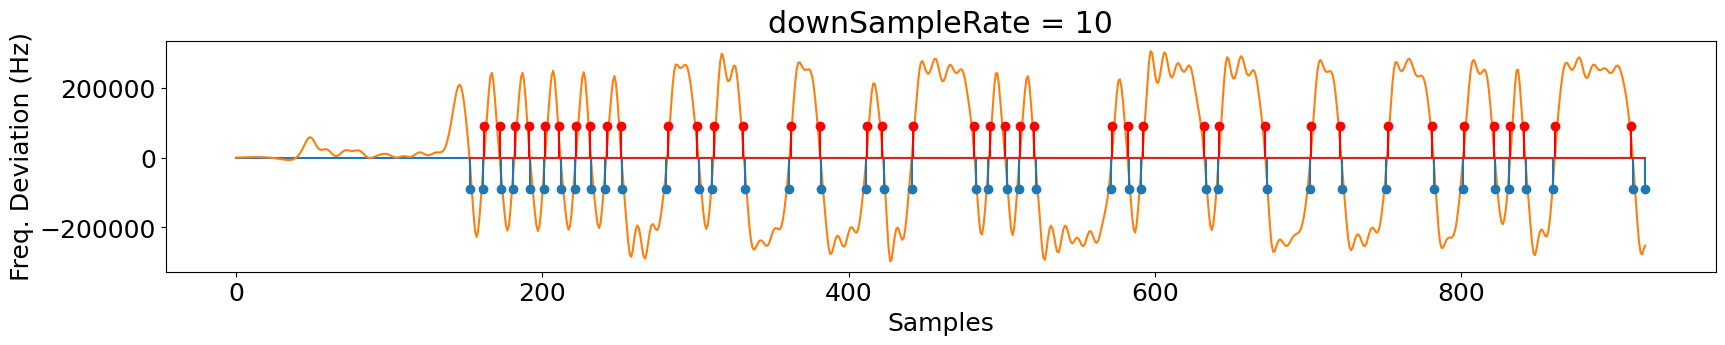

In [ ]:
# How DownSampling effects the signal
downSampleRate = 10
methods={                                      
    iq.bitFinderFromPhaseGradient:{'Fs': 10e6, 'smallerThan': 100, 'biggerThan': 7, 'noGroupBefore': 125, 'plot': True, "title": 'downSampleRate = 10'},
    iq.scalePhaseGradientToHz: {'Fs': iq.Fs/downSampleRate}, 
    iq.gradient:{},
    iq.unwrapPhase:{},
    iq.phase:{}, 
    iq.butter:{'Fs': iq.Fs/downSampleRate},
    iq.downSample:{'downSampleRate':downSampleRate, "shift": 0},
    iq.demodulate:{'Fs': iq.Fs},
}
yy10 = iq.apply(methods=methods, frame = X[0:1])
